CT with UNet for Denoising of FBP
=================================

This example demonstrates the training and application of UNet
to denoise previously filtered back projections (FBP) for CT
reconstruction inspired by <cite data-cite="jin-2017-unet"/>.

In [1]:
import os
from time import time

import jax

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scico import flax as sflax
from scico import metric, plot
from scico.flax.examples import load_ct_data
plot.config_notebook_plotting()

Prepare parallel processing. Set an arbitrary processor
count (only applies if GPU is not available).

In [2]:
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"
platform = jax.lib.xla_bridge.get_backend().platform
print("Platform: ", platform)

Platform:  gpu


Read data from cache or generate if not available.

In [3]:
N = 256  # phantom size
train_nimg = 536  # number of training images
test_nimg = 64  # number of testing images
nimg = train_nimg + test_nimg
n_projection = 45  # CT views

trdt, ttdt = load_ct_data(train_nimg, test_nimg, N, n_projection, verbose=True)

Data read from path       :   ~/.cache/scico/examples/data
Set --training--          :   Size:   536
Set --testing --          :   Size:   64
Data range --images  --   :    Min:   0.00, Max: 1.00
Data range --sinogram--   :    Min:   0.00, Max: 0.67
Data range --FBP     --   :    Min:   0.00, Max: 1.00


Build training and testing structures. Inputs are the filter
back-projected sinograms and outpus are the original generated foams.
Keep training and testing partitions.

In [4]:
train_ds = {"image": trdt["fbp"], "label": trdt["img"]}
test_ds = {"image": ttdt["fbp"], "label": ttdt["img"]}

Define configuration dictionary for model and training loop.

Parameters have been selected for demonstration purposes and relatively short training.
The model depth controls the levels of pooling in the U-Net model.
The block depth controls the number of layers at each level of depth.
The number of filters controls the number of filters at the input and output levels and doubles (halves)
at each pooling (unpooling) operation.
Better performance may be obtained by increasing depth, block depth, number of filters or training epochs,
but may require longer training times.

In [5]:
# model configuration
model_conf = {
    "depth": 2,
    "num_filters": 64,
    "block_depth": 2,
}
# training configuration
train_conf: sflax.ConfigDict = {
    "seed": 0,
    "opt_type": "SGD",
    "momentum": 0.9,
    "batch_size": 16,
    "num_epochs": 200,
    "base_learning_rate": 1e-2,
    "warmup_epochs": 0,
    "log_every_steps": 1000,
    "log": True,
}

Construct UNet model.

In [6]:
channels = train_ds["image"].shape[-1]
model = sflax.UNet(
    depth=model_conf["depth"],
    channels=channels,
    num_filters=model_conf["num_filters"],
    block_depth=model_conf["block_depth"],
)

Run training loop.

In [7]:
workdir = os.path.join(os.path.expanduser("~"), ".cache", "scico", "examples", "unet_ct_out")
train_conf["workdir"] = workdir
print(f"{'JAX process: '}{jax.process_index()}{' / '}{jax.process_count()}")
print(f"{'JAX local devices: '}{jax.local_devices()}")


# Construct training object
trainer = sflax.BasicFlaxTrainer(
    train_conf,
    model,
    train_ds,
    test_ds,
)

start_time = time()
modvar, stats_object = trainer.train()
time_train = time() - start_time

JAX process: 0 / 1
JAX local devices: [StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=1, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=2, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=3, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=4, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=5, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=6, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=7, process_index=0, slice_index=0)]
Channels: 1, training signals: 536, testing signals: 64, signal size: 256
+----------------------------------------------------+------------------+---------+-----------+--------+
| Name                                               | Shape            | Size    | Mean      | Std    |
+----------------------------------------------------+------------------+---------+-----------+--------+
| ConvBNMultiBlock_0/ConvBNBlock_0/BatchNorm_0/bias  | (64,)        

2022-11-28 11:18:05.781491: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:751] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,64,258,258]{3,2,1,0}, f32[2,64,256,256]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2022-11-28 11:18:05.975649: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:751] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[128,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,64,258,258]{3,2,1,0}, f32[2,128,256,256]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\"

Initial compilation completed.
Epoch  Time      Train_LR  Train_Loss  Train_SNR  Eval_Loss  Eval_SNR
---------------------------------------------------------------------
   30  5.16e+01  0.010000    0.012125       7.38   0.006184      8.71
   60  9.07e+01  0.010000    0.005833       8.97   0.005452      9.25
   90  1.30e+02  0.010000    0.005365       9.33   0.005131      9.52
  121  1.70e+02  0.010000    0.005117       9.53   0.004938      9.68
  151  2.10e+02  0.010000    0.004958       9.67   0.004810      9.80
  181  2.50e+02  0.010000    0.004844       9.77   0.004711      9.89


Evaluate on testing data.

In [8]:
start_time = time()
fmap = sflax.FlaxMap(model, modvar)
output = fmap(test_ds["image"])
time_eval = time() - start_time
output = jax.numpy.clip(output, a_min=0, a_max=1.0)

Compare trained model in terms of reconstruction time
and data fidelity.

In [9]:
snr_eval = metric.snr(test_ds["label"], output)
psnr_eval = metric.psnr(test_ds["label"], output)
print(
    f"{'UNet training':15s}{'epochs:':2s}{train_conf['num_epochs']:>5d}{'':21s}{'time[s]:':10s}{time_train:>7.2f}"
)
print(
    f"{'UNet testing':15s}{'SNR:':5s}{snr_eval:>5.2f}{' dB'}{'':3s}{'PSNR:':6s}{psnr_eval:>5.2f}{' dB'}{'':3s}{'time[s]:':10s}{time_eval:>7.2f}"
)

UNet training  epochs:  200                     time[s]:   275.43
UNet testing   SNR:  9.98 dB   PSNR: 20.35 dB   time[s]:     8.38


Plot comparison.

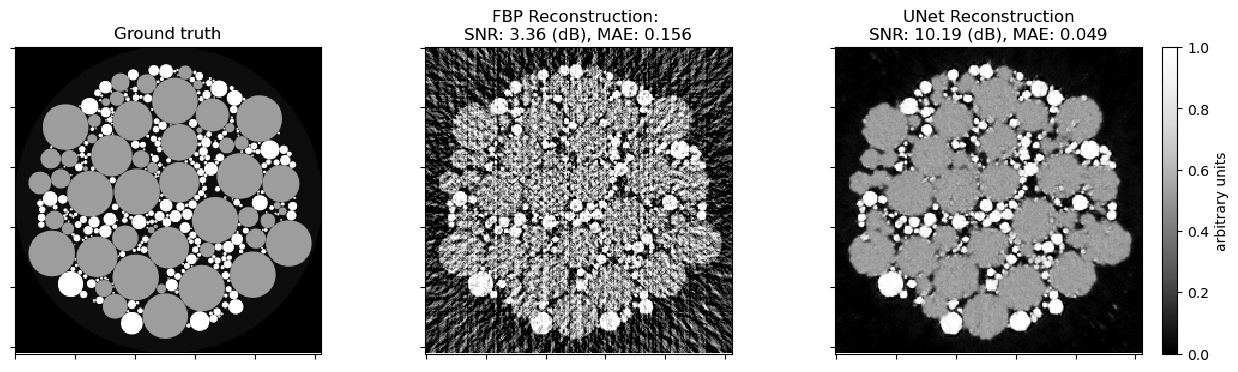

In [10]:
key = jax.random.PRNGKey(123)
indx = jax.random.randint(key, shape=(1,), minval=0, maxval=test_nimg)[0]

fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(test_ds["label"][indx, ..., 0], title="Ground truth", cbar=None, fig=fig, ax=ax[0])
plot.imview(
    test_ds["image"][indx, ..., 0],
    title="FBP Reconstruction: \nSNR: %.2f (dB), MAE: %.3f"
    % (
        metric.snr(test_ds["label"][indx, ..., 0], test_ds["image"][indx, ..., 0]),
        metric.mae(test_ds["label"][indx, ..., 0], test_ds["image"][indx, ..., 0]),
    ),
    cbar=None,
    fig=fig,
    ax=ax[1],
)
plot.imview(
    output[indx, ..., 0],
    title="UNet Reconstruction\nSNR: %.2f (dB), MAE: %.3f"
    % (
        metric.snr(test_ds["label"][indx, ..., 0], output[indx, ..., 0]),
        metric.mae(test_ds["label"][indx, ..., 0], output[indx, ..., 0]),
    ),
    fig=fig,
    ax=ax[2],
)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(ax[2].get_images()[0], cax=cax, label="arbitrary units")
fig.show()

Plot convergence statistics. Statistics only generated if a training cycle was done (i.e. not reading final epoch results from checkpoint).

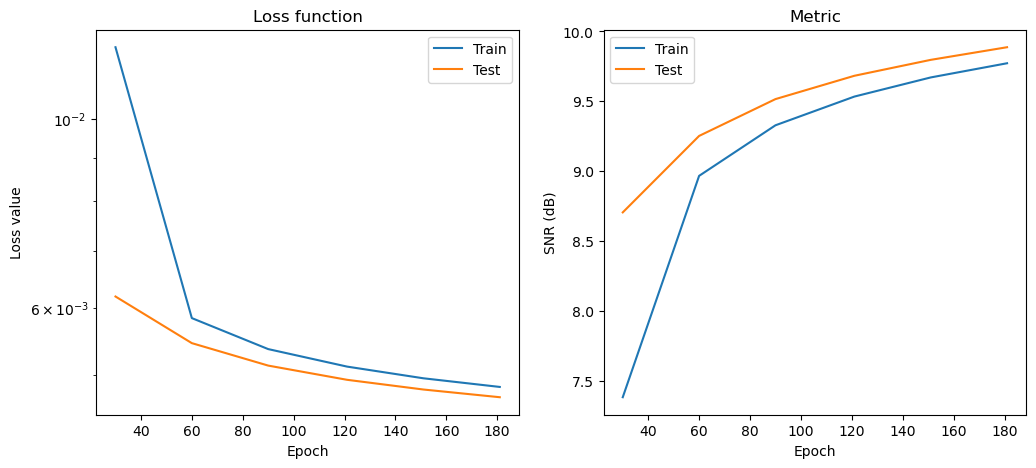

In [11]:
if stats_object is not None:
    hist = stats_object.history(transpose=True)
    fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plot.plot(
        jax.numpy.vstack((hist.Train_Loss, hist.Eval_Loss)).T,
        x=hist.Epoch,
        ptyp="semilogy",
        title="Loss function",
        xlbl="Epoch",
        ylbl="Loss value",
        lgnd=("Train", "Test"),
        fig=fig,
        ax=ax[0],
    )
    plot.plot(
        jax.numpy.vstack((hist.Train_SNR, hist.Eval_SNR)).T,
        x=hist.Epoch,
        title="Metric",
        xlbl="Epoch",
        ylbl="SNR (dB)",
        lgnd=("Train", "Test"),
        fig=fig,
        ax=ax[1],
    )
    fig.show()